In [1]:
%cd ../..

/home/denis/code/study/ComputerVisionTasks


# Проведение исследований с моделями классификации

In [2]:
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from torch import nn
from functools import partial
from fastai.vision.all import (top_k_accuracy,
                               accuracy,
                               F1Score,
                               Precision,
                               Recall,
                               DataLoaders,
                               CrossEntropyLossFlat,
                               EarlyStoppingCallback,
                               MixUp,
                               Learner)

/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_H = img_W = 224

In [4]:
metrics_list = [
    accuracy,
    partial(top_k_accuracy, k=3),
    partial(top_k_accuracy, k=5),
    F1Score(average='macro'),
    Precision(average='macro'),
    Recall(average='macro')
]

In [5]:
def show_random_images(dataset, num_images=10, denormalize=True, 
                       mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Отображает случайные изображения из датасета с их классами.

    Параметры:
      dataset: датасет, возвращающий кортеж (image, label), где image - тензор в формате (C, H, W)
      num_images: количество случайных изображений для отображения
      denormalize: если True, денормализует изображение (требует, чтобы Normalize использовался с указанными mean и std)
      mean, std: параметры нормализации, применяемые к датасету
    """
    indices = random.sample(range(len(dataset)), num_images)

    n_cols = 5
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    if n_rows == 1:
        axs = axs.flatten()
    else:
        axs = [ax for row in axs for ax in row]

    for ax, idx in zip(axs, indices):
        image, label = dataset[idx]
        if denormalize:
            image_denorm = image.clone()
            for t, m, s in zip(image_denorm, mean, std):
                t.mul_(s).add_(m)
            image_denorm = image_denorm.clamp(0, 1)
        else:
            image_denorm = image

        image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    for ax in axs[len(indices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [6]:
p = 0.2
train_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Rotate(limit=(0, 90), p=p),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=p),  # случайный поворот на кратные 90 градусов
    A.Transpose(p=p),       # случайная транспозиция
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=p),
    # Убираем нераспознаваемые аргументы:
    A.GaussNoise(p=p),                # добавление гауссовского шума
    A.RandomFog(p=p),                 # имитация облаков/тумана
    A.RandomSunFlare(p=p),            # эффект блика или солнечного сияния
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), p=p),
    A.CoarseDropout(p=p),             # случайное "вытирание" небольших участков
    A.ElasticTransform(p=p),          # эластичное искажение изображения
    # Вместо height и width передаём size
    A.RandomResizedCrop(size=(img_H, img_W), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=p),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

valid_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def transform_train(pil_image):
    image_np = np.array(pil_image)
    augmented = train_album(image=image_np)
    return augmented['image']

def transform_valid(pil_image):
    image_np = np.array(pil_image)
    augmented = valid_album(image=image_np)
    return augmented['image']

In [7]:
train_ds, valid_ds, test_ds = ImageFolder(root='./data/PatternNet/train', transform=transform_train),\
                              ImageFolder(root='./data/PatternNet/validation', transform=transform_valid),\
                              ImageFolder(root='./data/PatternNet/test', transform=transform_valid)

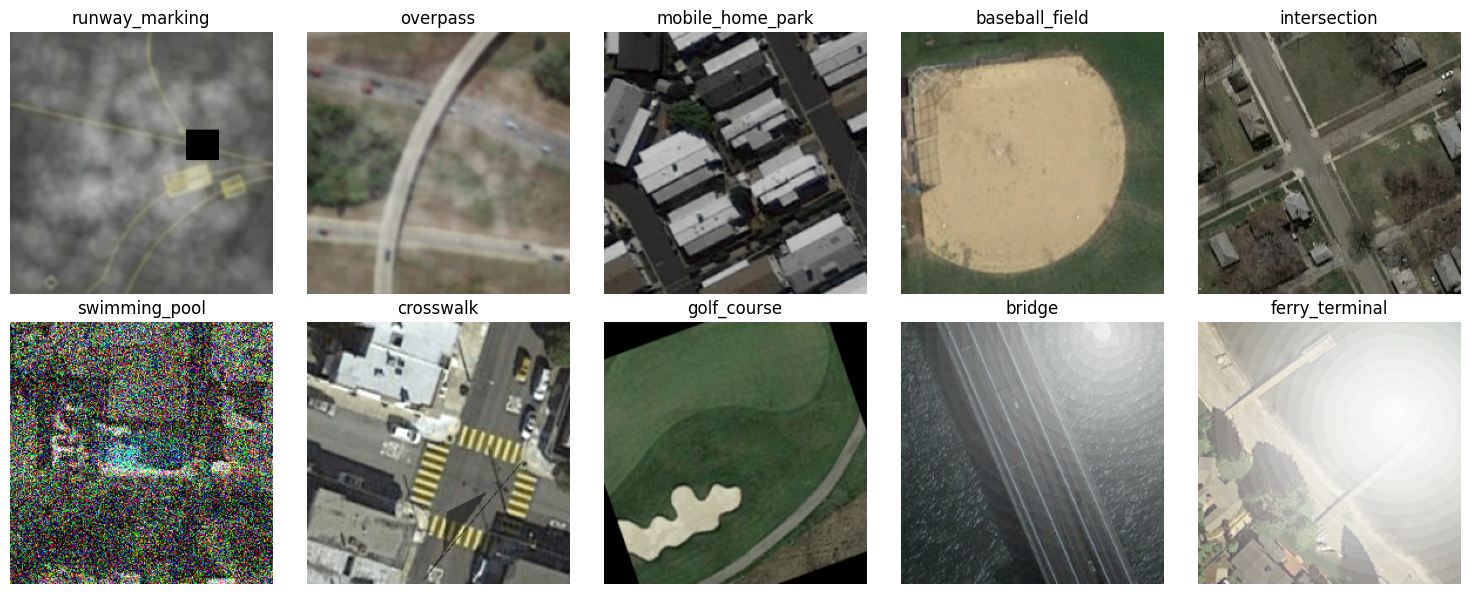

In [8]:
# Отобразить 10 случайных изображений:
show_random_images(train_ds, num_images=10)

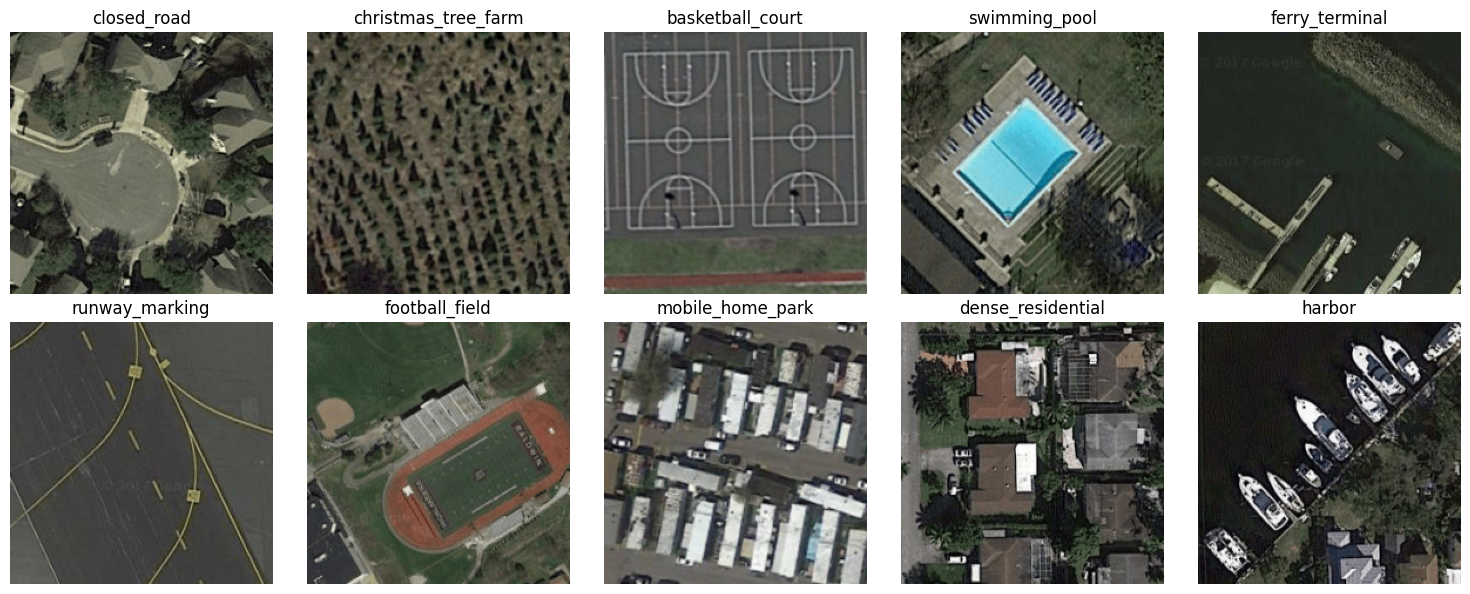

In [9]:
# Отобразить 10 случайных изображений:
show_random_images(valid_ds, num_images=10)

In [10]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, test_ds, bs=64, num_workers=0)
dls = dls.cuda()

In [11]:
# Сверточная модель: Convnext
conv_model = models.convnext_base(pretrained=True)
in_features = conv_model.classifier[2].in_features
conv_model.classifier[2] = nn.Linear(in_features, len(train_ds.classes))

for name, param in conv_model.named_parameters():
    if 'classifier.2' not in name:
        param.requires_grad = False

conv_model.to("cuda")

/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [12]:
loss_func = CrossEntropyLossFlat(label_smoothing=0.1)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=2)
mixup_cb = MixUp()

In [13]:
learn = Learner(dls, conv_model, loss_func=loss_func, metrics=metrics_list, 
                cbs=[early_stop_cb, mixup_cb])

In [14]:
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,1.884121,0.892674,0.966941,0.995395,0.998520,0.967155,0.968605,0.966941,14:29


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,1.780792,0.870182,0.971053,0.998520,0.999836,0.971419,0.973425,0.971053,14:59
1,1.727421,0.850499,0.978454,0.998355,0.999507,0.978616,0.979253,0.978454,15:22
2,1.691203,0.844274,0.978783,0.998849,0.999507,0.978899,0.979305,0.978783,15:38


In [15]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")

Test results: [0.8376330137252808, 0.9837170839309692, 0.9986842274665833, 0.9998355507850647, 0.9838043055402735, 0.9840725571825548, 0.9837171052631579]


In [16]:
# Трансформерная модель: Vision Transformer (ViT-B/16)
vit_model = models.vit_b_16(pretrained=True)
in_features_vit = vit_model.heads.head.in_features
vit_model.heads.head = nn.Linear(in_features_vit, len(train_ds.classes))

for name, param in vit_model.named_parameters():
    if 'heads.head' not in name:
        param.requires_grad = False

vit_model.to("cuda")

/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/denis/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [17]:
learn = Learner(dls, vit_model, loss_func=loss_func, metrics=metrics_list, 
                cbs=[early_stop_cb, mixup_cb])

In [18]:
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,1.854076,0.936079,0.949178,0.993421,0.997697,0.949929,0.953169,0.949178,15:22


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,1.711742,0.893005,0.966118,0.995395,0.998520,0.966349,0.968082,0.966118,15:18
1,1.660130,0.868665,0.971217,0.996546,0.999013,0.971395,0.972050,0.971217,15:21
2,1.631286,0.862503,0.974178,0.997533,0.999178,0.974334,0.974769,0.974178,15:20


In [19]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")

Test results: [0.8539229035377502, 0.9792762994766235, 0.9970394968986511, 0.9991776347160339, 0.9792648676414645, 0.9794688790888256, 0.9792763157894738]


: 